['dec', 7, 0, 8, 4, 12, 2, 10, 6, 14, 1, 9, 5, 13, 3, 11, 15]
   bin(qiskit)  0000  1000  0100  1100  0010  1010  0110  1110  0001  1001  \
0          dec     0     1     2     3     4     5     6     7     8     9   
1       step:0     0     0     0     0     0     0     0  1200     0     0   
2       step:1     0     0     0     0     0     0   590     0   610     0   
3       step:2     0     0     0     0     0   323     0   591     0   286   
4       step:3     0     0     0     0   180     0   460     0   426     0   
5       step:4     0     0     0    75     0   454     0   144     0   450   
6       step:5     0     0    29     0   432     0   143     0   147     0   
7       step:6     0    12     0   345     0   132     0   166     0   184   
8       step:7    11     0   260     0   203     0   123     0   126     0   
9       step:8     0   169     0   277     0   100     0    82     0    98   
10      step:9   131     0   297     0    74     0    96     0    78     0   

 

/tmp/ipykernel_7089/1825308162.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.iloc[0, 1:].sort_values().index.tolist(), rotation=45)
/tmp/ipykernel_7089/1825308162.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.iloc[0, 1:].sort_values().index.tolist(), rotation=45)
/tmp/ipykernel_7089/1825308162.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.iloc[0, 1:].sort_values().index.tolist(), rotation=45)
/tmp/ipykernel_7089/1825308162.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.iloc[0, 1:].sort_values().index.tolist(), rotation=45)
/tmp/ipykernel_7

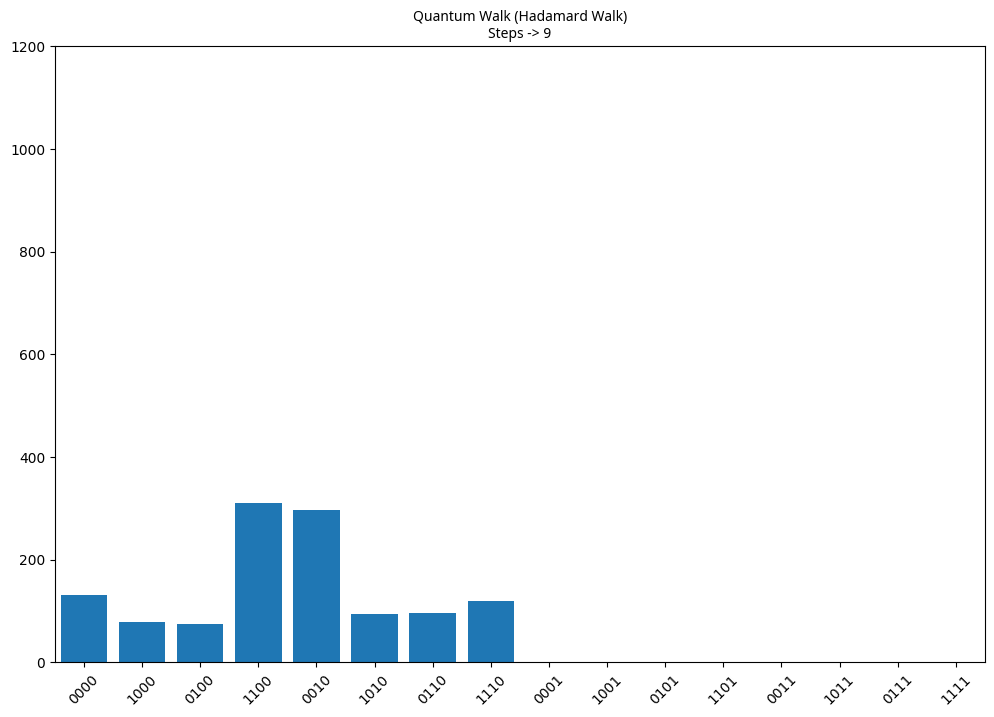

In [1]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.primitives import StatevectorSampler

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import pandas as pd
from matplotlib.font_manager import FontProperties

#--- Parameters
numBitPosition = 4  # qubit for positions
numBitCoin = 1  # qubit for states

# Function to create the quantum walk circuit with a given number of steps
def create_quantum_walk_circuit(qwStep):
    qc = QuantumCircuit(numBitPosition + numBitCoin, numBitPosition)
    
    # Initial state
    qc.x(1)
    qc.x(2)
    qc.x(3)

    # Coin flip and barrier
    qc.h(numBitPosition)
    qc.s(numBitPosition)
    qc.barrier()
    
    # Quantum walk steps
    for i in range(qwStep):
        # Coin flip
        qc.h(4)
        # Shift <adder>
        qc.x(4)
        qc.cx(4, 3)
        qc.ccx(4, 3, 2)
        qc.mcx([4, 3, 2], 1)
        qc.mcx([4, 3, 2, 1], 0)
        # Shift <subtractor>
        qc.x(4)
        qc.mcx([4, 3, 2, 1], 0)
        qc.mcx([4, 3, 2], 1)
        qc.ccx(4, 3, 2)
        qc.cx(4, 3)
    
    # Measurement
    qc.barrier()
    qc.measure([0, 1, 2, 3], [0, 1, 2, 3])
    
    return qc

# Function to fill counts with zero counts for missing bitstrings
def fill_counts_with_zeros(counts, numBitPosition):
    def decimal_to_base(n, base):
        return format(n, f'{base}')
    
    bitBase = numBitPosition
    base = f'0{bitBase}b'
    
    for i in range(2 ** numBitPosition):
        binary_number = decimal_to_base(i, base)
        if binary_number not in counts:
            counts[binary_number] = 0
    
    return counts

# Simulator settings
shots = 1200
sampler = StatevectorSampler()

# Number of executions (steps)
num_executions = 10

# Log of results
results_log = []

for steps in range(num_executions):
    qc = create_quantum_walk_circuit(steps)
    result = sampler.run([qc], shots=shots).result()
    
    # Access result data for PUB 0
    data_pub = result[0].data
    
    # Get counts for the classical register "meas"
    counts = data_pub.c.get_counts()
    
    # Fill counts with zero counts for missing bitstrings
    counts = fill_counts_with_zeros(counts, numBitPosition)
    
    results_log.append(counts)

# Convert log to DataFrame
df = pd.DataFrame(results_log).fillna(0).astype(int)

# Insert col
df.insert(0, 'bin(qiskit)', [f'step:{i}' for i in range(num_executions)])

# insert row(decimal)
header_list = df.columns.tolist()

def is_binary_string(s):
    return all(c in '01' for c in s)

# Convert qiskit byte order to reverse order
def reverse_and_convert(header_list):
    converted_list = []

    for item in header_list:
        if not is_binary_string(item):
            if item == 'bin(qiskit)' :
                item = 'dec'
            converted_list.append(item)
            continue
        reversed_item = item[::-1]
        decimal_value = int(reversed_item, 2)
        converted_list.append(decimal_value)
    return converted_list

converted_list = reverse_and_convert(header_list)
print(converted_list)

new_df = pd.DataFrame([converted_list], columns=df.columns)
df = pd.concat([new_df, df], ignore_index=True)

# decの小さい順に列を並べ替える
sorted_columns = ['bin(qiskit)'] + df.iloc[0, 1:].sort_values().index.tolist()
df = df[sorted_columns]

# Save DataFrame to CSV file
df.to_csv('quantum_walk_results.csv', index=False)

# Display the table
print(df)

# Create histogram video from DataFrame with specified font and sorted by dec values
def create_histogram_video_from_df(df, output_file, num_executions, shots):
    fig, ax = plt.subplots(figsize=(12, 8))  # グラフを大きくするためにfigsizeを指定
    
    # Set font properties
    font_path = '/usr/share/fonts/truetype/NotoSans-Regular.ttf'
    font_prop = FontProperties(fname=font_path)

    def update_hist(num):
        ax.clear()
        data = df.iloc[num + 1, 1:]  # 最初の行はヘッダーなのでスキップ
        
        # Sort data by dec values (columns are already sorted by dec values)
        sorted_data = data.sort_index()
        
        ax.bar(sorted_data.index, sorted_data.values)
        
        # Set x-axis labels to dec values
        ax.set_xticklabels(df.iloc[0, 1:].sort_values().index.tolist(), rotation=45)
        
        ax.set_title(f'Quantum Walk (Hadamard Walk)\nSteps -> {num}', fontproperties=font_prop)
        ax.set_xlim(-0.5, len(sorted_data) - 0.5)  # X軸の範囲を固定
        ax.set_ylim(0, shots)  # Y軸の範囲をショット数に固定

    ani = FuncAnimation(fig, update_hist, frames=num_executions, repeat=False)
    
    ani.save(output_file, writer=PillowWriter(fps=2))

# Create histogram video from DataFrame with specified font and sorted by dec values
create_histogram_video_from_df(df, 'histogram_animation_from_df.png', num_executions, shots)
